### TODO LIST
3. select positive true_cm_g1 and negative true_cm_g2 objects and calculate g_i by formula
4. fit linearly 
5. compare real value
6. upper limit of snr
7. hump
8. select objects with input shape and repeat
9. read covariance, point-correlation function

# Header

In [1]:
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt
import pylab
import numpy as np
import h5py
from astropy.io import fits
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

In [2]:
detect = fits.open('/lsst/troxel/balrog/balrog_detection_catalog-v1.2.fits')[-1]
phot   = fits.open('/lsst/troxel/balrog/balrog_matched_catalog_flatten.fits')
id_balrog = fits.open('/lsst/troxel/balrog/balrog_mcal_bal_ids_v1.2.fits')

#all objects riz
mcal   = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-mcal-v1.2.h5','r')['catalog'] #with neighbor
mcal1  = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-noNB-mcal-v1.2.h5','r')['catalog'] #no neighbor
#only balrog objects riz
mcal2=h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-mcal-1.3.h5','r')['catalog'] #with neighbor
mcal3=h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-noNB-mcal-1.3.h5','r')['catalog'] #no neighbor

#only balrog griz
mcal4=h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-griz-mcal-1.3.h5','r')['catalog'] #with neighbor
mcal5=h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-griz-noNB-mcal-1.3.h5','r')['catalog'] #no neighbor

In [3]:
[key for key in list(mcal['unsheared'].keys()) if key not in list(mcal1['unsheared'].keys())]
print(list(mcal['unsheared'].keys()))
print(list(mcal2['unsheared'].keys()))

['R11', 'R12', 'R21', 'R22', 'T', 'T_err', 'coadd_object_id', 'covmat_0_1', 'covmat_1_1', 'covmat_2_2', 'dec', 'e_1', 'e_2', 'flags', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_r', 'flux_z', 'mask_frac', 'mcal_psf_T', 'mcal_psf_e1', 'mcal_psf_e2', 'nimage_tot_i', 'nimage_tot_r', 'nimage_tot_z', 'nimage_use_i', 'nimage_use_r', 'nimage_use_z', 'psf_T', 'psf_e1', 'psf_e2', 'ra', 'size_ratio', 'snr']
['R11', 'R12', 'R21', 'R22', 'T', 'T_err', 'bal_id', 'coadd_object_id', 'covmat_0_1', 'covmat_1_1', 'covmat_2_2', 'dec', 'e_1', 'e_2', 'flags', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_r', 'flux_z', 'mask_frac', 'mcal_psf_T', 'mcal_psf_e1', 'mcal_psf_e2', 'nimage_tot_i', 'nimage_tot_r', 'nimage_tot_z', 'nimage_use_i', 'nimage_use_r', 'nimage_use_z', 'psf_T', 'psf_e1', 'psf_e2', 'ra', 'size_ratio', 'snr']


In [4]:
[key for key in list(mcal1['unsheared'].keys()) if key not in list(mcal['unsheared'].keys())]

[]

In [5]:
#setting cut threshold 
SNR_CUT = 10
SIZE_RATIO_CUT = 0.5
T_CUT = 1000

In [6]:
# noinspection JupyterKernel,JupyterKernel
log_keys = ['snr','size_ratio','T','T_err','flux_i','flux_r','flux_z','covmat_1_1','covmat_1_2','covmat_2_1','covmat_2_2']
excluded_keys = ['coadd_object_id','flags','bal_id','flags']
excluded_balrog = excluded_keys + []

# Metadata

In [7]:
# FITS format code         Description                     8-bit bytes

# L                        logical (Boolean)               1
# X                        bit                             *
# B                        Unsigned byte                   1
# I                        16-bit integer                  2
# J                        32-bit integer                  4
# K                        64-bit integer                  4
# A                        character                       1
# E                        single precision floating point 4
# D                        double precision floating point 8
# C                        single precision complex        8
# M                        double precision complex        16
# P                        array descriptor                8
# Q                        array descriptor                16

In [8]:
def get_np_unsheared_array(catalog_array):
    catalog_array_unsheared=[]
    for catalog in catalog_array:
        data_dict={}
        for key in list(catalog['unsheared'].keys()):
            data_dict[key]=catalog['unsheared'][key].value
        catalog_array_unsheared.append(data_dict)
    return (catalog_array_unsheared)

In [9]:
name_array = ["mcal","mcal1","mcal2","mcal3","mcal4","mcal5"]
catalog_array = [mcal,mcal1,mcal2,mcal3,mcal4,mcal5]

In [10]:
catalog_array_unsheared=get_np_unsheared_array(catalog_array)
keys_array = [list(mcal.keys()) for mcal in catalog_array_unsheared]

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


## Masking function

In [11]:
def masking(catalog,SNR_CUT,SIZE_RATIO_CUT,T_CUT):
    snr_mask = np.ma.masked_greater(catalog['snr'][:],SNR_CUT)
    size_ratio_mask = np.ma.masked_greater(catalog['size_ratio'][:],SIZE_RATIO_CUT)
    T_mask = np.ma.masked_less(catalog['T'],T_CUT)
    mask_temp = np.logical_and(snr_mask.mask, size_ratio_mask.mask)
    mask = np.logical_and(mask_temp, T_mask.mask)
    return ([snr_mask,size_ratio_mask,T_mask,mask]) #index 3 is the final mask

In [12]:
def get_mask(catalog_array_unsheared):
    mask_array = []
    for catalog in catalog_array_unsheared:
        mask_array.append(masking(catalog,SNR_CUT,SIZE_RATIO_CUT,T_CUT))
    return (mask_array)

In [13]:
def print_mask():
    for i,catalog in enumerate(catalog_array_unsheared):
        print ("For {:5}, snr > {:3} mask cuts {:8} elements, size_ratio > {:4} mask cuts {:8} elements, T > {:5} mask cuts {:5} elements".format
          (name_array[i],SNR_CUT,np.sum(~mask_array[i][0].mask),SIZE_RATIO_CUT,np.sum(~mask_array[i][1].mask),T_CUT,np.sum(~mask_array[i][2].mask)))

In [14]:
mask_array = get_mask(catalog_array_unsheared)

In [15]:
print_mask()

For mcal , snr >  10 mask cuts 13422282 elements, size_ratio >  0.5 mask cuts 32006643 elements, T >  1000 mask cuts  9735 elements
For mcal1, snr >  10 mask cuts  3913239 elements, size_ratio >  0.5 mask cuts 27655652 elements, T >  1000 mask cuts  6111 elements
For mcal2, snr >  10 mask cuts  1278712 elements, size_ratio >  0.5 mask cuts  2904838 elements, T >  1000 mask cuts   110 elements
For mcal3, snr >  10 mask cuts   348328 elements, size_ratio >  0.5 mask cuts  2418812 elements, T >  1000 mask cuts   280 elements
For mcal4, snr >  10 mask cuts  1323055 elements, size_ratio >  0.5 mask cuts  3219819 elements, T >  1000 mask cuts   108 elements
For mcal5, snr >  10 mask cuts   207482 elements, size_ratio >  0.5 mask cuts  2756103 elements, T >  1000 mask cuts   283 elements


In [16]:
mask_array = [mask[3] for mask in mask_array]

# Std and mean

In [17]:
def mask_catalog_arrays(catalog_array,mask_array):
    masked_catalog = []
    for i,catalog in enumerate(catalog_array):
        data_dict = {}
        for key in list(catalog.keys()):
            data_dict[key] = catalog[key][mask_array[i]]
        masked_catalog.append(data_dict)
    return (masked_catalog)

In [18]:
masked_catalog = mask_catalog_arrays(catalog_array_unsheared,mask_array)

In [19]:
for catalog in masked_catalog:
    print(len(list(catalog.keys())))

36
36
37
37
41
41


In [20]:
def get_mean_std(masked_catalog):
    std_array=[]; mean_array=[]
    mean_dict={}
    std_dict={}
    for i, catalog in enumerate(masked_catalog):
        std_dict = {}
        mean_dict = {}
        for key in catalog:
            std_dict[key] = np.std(catalog[key])
            mean_dict[key] = np.mean(catalog[key])
        std_array.append(std_dict)
        mean_array.append(mean_dict)
    return(mean_array,std_array)

In [21]:
mean_array,std_array = get_mean_std(masked_catalog)

In [22]:
f = open('/home/cz136/project/balrog/data/hist/compare/val_stat.txt','w+')

sepbar = "------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n"
f.write ( "std in {:15} is:   {:10} {:10} {:10} {:10} {:10} {:10}| mean is: {:10} {:10} {:10} {:10} {:10} {:10} \n".format("column",*(name_array),*(name_array)))
f.write (sepbar)
for key in list(keys_array[4]):
    if key not in excluded_keys:
        if key in keys_array[0]:
            key_std = lambda key:[std_array[i][key] for i in range(len(std_array))]
            key_mean = lambda key:[mean_array[i][key] for i in range(len(mean_array))]
            f.write ("std in {:15} is: {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e}| mean is: {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e} \n".format(key,*key_std(key),*key_mean(key)))
        else:
            key_std=[None]*len(std_array)
            key_mean=[None]*len(std_array)
            for i in range(len(std_array)):
                if key in std_array[i]:
                    key_std[i] = std_array[i][key]
                    key_mean[i]=mean_array[i][key]
                else:
                    key_std[i]=float("NaN")
                    key_mean[i] = float("NaN")
            f.write ("std in {:15} is: {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e}| mean is: {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e} {:10.3e} \n".format(key,*key_std,*key_mean))
        f.write (sepbar)
f.close()

# Plotting

In [23]:
import os
import errno

def mkdir_p(mypath):    
    try:  
        os.mkdir(mypath)
    except OSError as e:  
        if e.errno != errno.EEXIST:
            raise
        pass

In [24]:
def hist_compare(catalog1,catalog2):

    index1 = catalog_array.index(catalog1)
    index2 = catalog_array.index(catalog2)
    
    name1 = name_array[index1]
    name2 = name_array[index2]
    
    for i,key in enumerate(list(catalog1['unsheared'].keys())):
        data1 = catalog1['unsheared'][key][:][mask_array[index1][3]]
        data2= catalog2['unsheared'][key][:][mask_array[index2][3]]

        lower1 = mean_array[index1][key] - 2*std_array[index1][key]
        upper1 = mean_array[index1][key] + 2*std_array[index1][key]
        lower2 = mean_array[index2][key] - 2*std_array[index2][key]
        upper2 = mean_array[index2][key] + 2*std_array[index2][key]
        lower = lower1 if lower1 <= lower2 else lower2;
        upper = upper1 if upper1 >= upper2 else upper2;


        fig = plt.figure();
        ax = fig.add_subplot(111)
        
        if key in excluded_keys:
            continue
        elif key in log_keys:
            lower = 10**(-2) if lower <= 0 else lower;
            BINS = 10 ** np.linspace(np.log10(lower),np.log10(upper))
            H1 = plt.hist(data1,label ='{}'.format(name_array[index1]),bins=BINS,log=True,histtype = 'step');
            H2 = plt.hist(data2,label ='{}'.format(name_array[index2]),bins=BINS,log=True,histtype = 'step');
            plt.xscale('log')
    #     elif key in flux_keys:
    #         data = 30 - 2.5 * np.log10(data)
    #         H = plt.hist(data,label=labels,bins=100)
        else:
            H1 = plt.hist(data1,label ='{}'.format(name1),log=True, bins = 100,histtype = 'step');
            H2 = plt.hist(data2,label ='{}'.format(name2),log=True, bins = 100,histtype = 'step');
        ax.text(1,1,'{:5}:std={:05.3e} mean={:05.3e} \n {:5}:std={:05.3e} mean={:05.3e}'
                .format(name1,std_array[index1][key],mean_array[index1][key],name2,std_array[index2][key],mean_array[index2][key])
                ,verticalalignment = 'top',horizontalalignment = 'right',
        transform=ax.transAxes,color='black',fontsize=7)
        
        plt.xlabel(key)
        plt.ylabel("frequency")
    #     plt.legend(loc=0)
    
        plt.title("Histogram of {}".format(key));
        output_dir = "./hist/compare/{}_{}".format(name1,name2)
        mkdir_p("./hist/compare")
        mkdir_p(output_dir)
        plt.savefig("{}/{}".format(output_dir,key),dpi=300);
        plt.close()

# Calculate g_i

In [25]:
def g(e, R):
    return (e/R)

In [26]:
def get_g_array(mean_array):
    g_array = []
    for i in range(len(mean_array)):
        g_temp_array = []
        for j in range(1,3):
            g_temp_array.append(g(mean_array[i]['e_'+str(j)], mean_array[i]['R'+str(j)+str(j)]))
        g_array.append(g_temp_array)
    return(g_array)

In [27]:
g_array=get_g_array(mean_array)

In [28]:
for array in g_array:
    print ("g1: {:10.3e} g2:{:10.3e}".format(*array))

g1:  5.353e-04 g2: 3.187e-04
g1:  1.108e-03 g2: 5.022e-04
g1:  2.629e-03 g2: 4.795e-04
g1:  3.369e-03 g2: 8.772e-04
g1:  2.329e-03 g2: 7.499e-04
g1:  3.296e-03 g2: 9.642e-04


# Difference comparing

### Testing whether one set is the subset of the other

In [29]:
index_array = []

def get_intersected_mask(catalog1,catalog2):
    
    id_array_1 = catalog1['bal_id'][:]
    id_array_2 = catalog2['bal_id'][:]

    mask1 = np.in1d(id_array_1,id_array_2)
    mask2 = np.in1d(id_array_2,id_array_1)

    if np.sum(mask1)==np.sum(mask2):
        print("The number of elements after taking the intersection of two sets are {}".format(np.sum(mask1)))
        print("The intersection operation takes {} elements from array1".format(len(id_array_1)-np.sum(mask1)))
        print("The intersection operation takes {} elements from array2".format(len(id_array_2)-np.sum(mask2)))

    if np.all((id_array_1[mask1] == id_array_2[mask2])):
        print("The balrog ids are two identical arrays after masking.")
        
    return(mask1,mask2)

In [30]:
mask2,mask3=get_intersected_mask(catalog_array_unsheared[2],catalog_array_unsheared[3])
mask4,mask5=get_intersected_mask(catalog_array_unsheared[4],catalog_array_unsheared[5])

The number of elements after taking the intersection of two sets are 4320506
The intersection operation takes 44847 elements from array1
The intersection operation takes 17552 elements from array2
The balrog ids are two identical arrays after masking.
The number of elements after taking the intersection of two sets are 4382602
The intersection operation takes 303 elements from array1
The intersection operation takes 0 elements from array2
The balrog ids are two identical arrays after masking.


In [31]:
bal_mask_array=[mask2,mask3,mask4,mask5]
bal_catalog_array=catalog_array_unsheared[2:6]

In [32]:
def get_bal_masked_dict(old_dict,mask):
    masked_dict={}
    for key in tqdm(old_dict.keys()):
        masked_dict[key]=old_dict[key][mask]
    return (masked_dict)

In [33]:
catalog_bal_masked=[]
for i in range(len(bal_mask_array)):
    catalog_bal_masked.append(get_bal_masked_dict(bal_catalog_array[i],bal_mask_array[i]))

100%|██████████| 41/41 [00:01<00:00, 34.83it/s]


In [34]:
print (len(catalog_bal_masked[0]['bal_id']))
print (len(catalog_bal_masked[1]['bal_id']))
print (len(catalog_bal_masked[2]['bal_id']))
print (len(catalog_bal_masked[3]['bal_id']))

4320506
4320506
4382602
4382602


### clipping the arrays with logical and

In [35]:
SNR_mask_array_for_bal_masked = [masking(catalog,SNR_CUT,SIZE_RATIO_CUT,T_CUT) for catalog in catalog_bal_masked]

In [36]:
print (len(SNR_mask_array_for_bal_masked[0][3]))
print (len(SNR_mask_array_for_bal_masked[1][3]))
print (len(SNR_mask_array_for_bal_masked[2][3]))
print (len(SNR_mask_array_for_bal_masked[3][3]))

4320506
4320506
4382602
4382602


In [37]:
def get_and_mask(catalog_array,mask_array):
    and_masked_array=[]
    mask_2_3 = np.logical_and(mask_array[0][3],mask_array[1][3])
    mask_4_5=np.logical_and(mask_array[2][3],mask_array[3][3])
    for i in range(2):
        and_masked_array.append(mask_2_3)
    for i in range(2):
        and_masked_array.append(mask_4_5)
    return (and_masked_array)

In [38]:
and_mask_array=get_and_mask(catalog_bal_masked,SNR_mask_array_for_bal_masked)

In [39]:
print (len(and_mask_array))

4


In [40]:
final_catalog_array=mask_catalog_arrays(catalog_bal_masked,and_mask_array)

In [41]:
def get_difference(catalog_w,catalog_wo,keys):
    diff_dict = {}
    frac_diff = {}

    for key in list(keys):
        diff_dict[key] = catalog_wo[key]-catalog_w[key]

    for key in list(keys):
        frac_diff[key] = np.array(diff_dict[key])/((np.array(catalog_wo[key])+np.array(catalog_w[key])/2))

    mean_diff = {}
    std_diff = {}
    
    for key in list(keys):
        std_diff[key] = np.std(diff_dict[key])
        mean_diff[key]= np.mean(diff_dict[key])

    std_frac = {}
    mean_frac = {}
    
    for key in list(keys):
        std_frac[key] = np.std(frac_diff[key])
        mean_frac[key]= np.mean(frac_diff[key])
        
    return(diff_dict,frac_diff,mean_diff,std_diff,std_frac,mean_frac)

### Plotting the absolute difference histogram

In [42]:
riz_keys=list(mcal['unsheared'].keys())
riz_balrog_keys=list(mcal2['unsheared'].keys())
griz_keys=list(mcal4['unsheared'].keys())

In [43]:
def diff_plot (name,keys, diff_dict,frac_diff,mean_diff,std_diff,std_frac,mean_frac):
    abs_name = name
    for i,key in enumerate(keys):

    # print (" {:05.2f}%".format(i*100/len(mcal_keys)),sep=' ', end='',flush=True)
        data = diff_dict[key][:]

        lower = mean_diff[key] - 2*std_diff[key]
        upper = mean_diff[key] + 2*std_diff[key]
        
    # plot abs difference

        fig = plt.figure();
        ax = fig.add_subplot(111);

        if key in excluded_balrog:
            continue
        elif key in log_keys:
            lower = 10**(-2) if lower <= 0 else lower;
            BINS = 10 ** np.linspace(np.log10(lower),np.log10(upper))
            H = plt.hist(data,label ='{}'.format(abs_name),bins=BINS,log=False,histtype = 'step');
            plt.xscale('log');
            plt.xlabel(key+' in log scale');
        else:
            H = plt.hist(data,label ='{}'.format(abs_name),log=False, bins = 50,histtype = 'step');
            plt.xlabel(key + " in linear scale");
        ax.text(1,1,'std={:05.3e} mean={:05.3e} count={:05.3e}'
                .format(std_diff[key],mean_diff[key],len(data)),verticalalignment = 'top',horizontalalignment = 'right',transform=ax.transAxes,color='black',fontsize=7);
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(axis='both',style='sci',scilimits=(0,0))
        plt.ylabel("frequency");
        plt.title("Histogram of Absolute Difference in {}".format(key));
        output_dir = "/home/cz136/project/balrog/data/hist/diff/{}".format(abs_name);
        mkdir_p(output_dir);
        plt.savefig("{}/{}".format(output_dir,key),dpi=400);
        plt.close()
            

In [44]:
def frac_plot (name,keys, diff_dict,frac_diff,mean_diff,std_diff,std_frac,mean_frac):
    frac_name = name
    for i,key in enumerate(keys):

    # print (" {:05.2f}%".format(i*100/len(mcal_keys)),sep=' ', end='',flush=True)
        data = frac_diff[key][:]

        lower = mean_frac[key] - 2*std_frac[key]
        upper = mean_frac[key] + 2*std_frac[key]
        
    # plot frac difference

        fig = plt.figure();
        ax = fig.add_subplot(111);

        if key in excluded_balrog:
            continue
        elif key in log_keys:
            lower = 10**(-2) if lower <= 0 else lower;
            BINS = 10 ** np.linspace(np.log10(lower),np.log10(upper))
            H = plt.hist(data,label ='{}'.format(frac_name),bins=BINS,log=True,histtype = 'step');
            plt.xscale('log');
            plt.xlabel(key+' in log scale');
        else:
            H = plt.hist(data,label ='{}'.format(frac_name),log=True, bins = 50,histtype = 'step');
            plt.xlabel("Fractional difference in " + key);
        ax.text(1,1,'std={:05.3e} mean={:05.3e} counts={:05.3e}'
                .format(std_frac[key],mean_frac[key],len(data)),verticalalignment = 'top',horizontalalignment = 'right',transform=ax.transAxes,color='black',fontsize=10);
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())
        plt.ylabel("Frequency");
#         ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
        plt.title("Histogram of Fractional Difference in {}".format(key));
        mkdir_p("/home/cz136/project/balrog/data/hist/diff/")
        output_dir = "/home/cz136/project/balrog/data/hist/diff/{}".format(frac_name);
        mkdir_p(output_dir);
        plt.savefig("{}/{}".format(output_dir,key),dpi=400);
        plt.close()

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


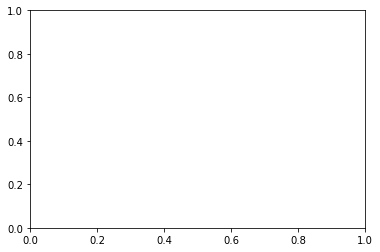

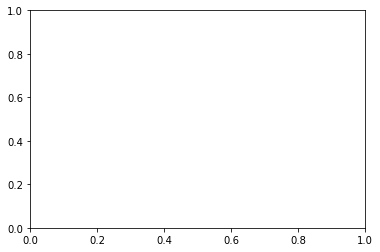

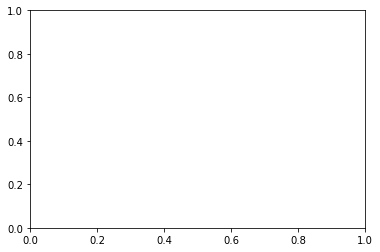

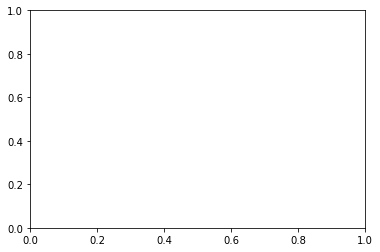

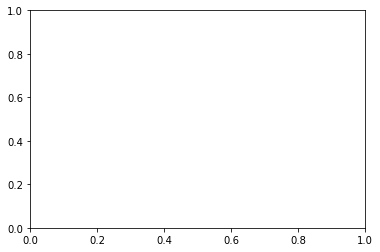

In [45]:
diff_plot("riz_abs_diff",riz_keys,*get_difference(final_catalog_array[0],final_catalog_array[1],riz_keys))
diff_plot("griz_abs_diff",griz_keys,*get_difference(final_catalog_array[2],final_catalog_array[3],griz_keys))

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


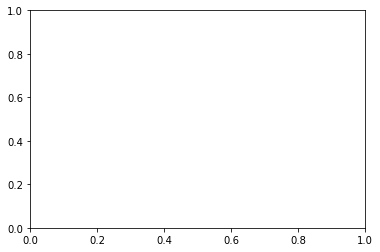

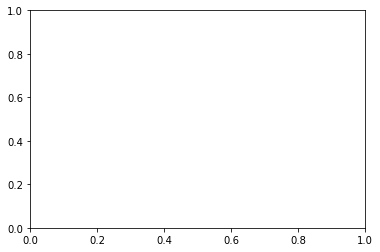

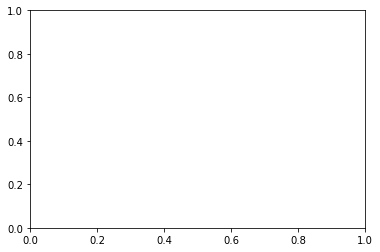

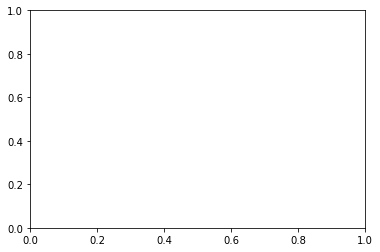

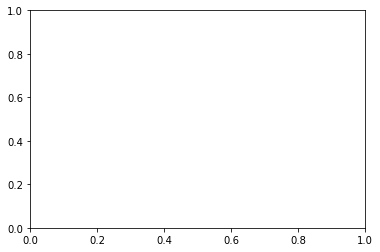

In [46]:
frac_plot("riz_frac_diff",riz_keys,*get_difference(final_catalog_array[0],final_catalog_array[1],riz_keys))
frac_plot("griz_frac_diff",griz_keys,*get_difference(final_catalog_array[2],final_catalog_array[3],griz_keys))

In [47]:
f = open('./hist/diff/diff_stat.txt','w+')

f.write ("{:15}      {:>15} {:>15} {:>15} {:>15} | {:>15} {:>15} {:>15} {:>15} \n".format("NAME", "abs_diff_riz", "frac_diff_riz", "abs_diff_griz","frac_diff_griz","abs_diff_riz", "frac_diff_riz", "abs_diff_griz","frac_diff_griz"  ))
f.write (sepbar)
for key in list(mcal_keys):
    if key not in excluded_keys:
        if key in mcal1_keys:
            f.write ("{:15}      {:15.3e} {:15.3e} {:15.3e} {:15.3e} | {:15.3e} {:15.3e} {:15.3e} {:15.3e} \n".format(key,riz_std_diff[key], riz_std_frac[key], griz_std_diff[key],griz_std_frac[key],riz_mean_diff[key], riz_mean_frac[key], griz_mean_diff[key],griz_mean_frac[key] ))
            f.write(sepbar)
        else:
#             key_std=[None]*len(std_array)
#             key_mean=[None]*len(std_array)
#             for i in range(len(std_array)):
#                 if key in std_array[i]:
#                     key_std[i] = std_array[i][key]
#                     key_mean[i]=mean_array[i][key]
#                 else:
#                     key_std[i]=float("NaN")
#                     key_mean[i] = float("NaN")
            f.write ("{:15}      {:15.3e} {:15.3e} {:15.3e} {:15.3e} | {:15.3e} {:15.3e} {:15.3e} {:15.3e} \n".format(key,float("NaN"),float("NaN") , griz_std_diff[key],griz_std_frac[key],float("NaN"), float("NaN"), griz_mean_diff[key],griz_mean_frac[key] ))
            f.write (sepbar)
f.close()




FileNotFoundError: [Errno 2] No such file or directory: './hist/diff/diff_stat.txt'

In [ ]:
test=get_difference(final_catalog_array[2],final_catalog_array[3],griz_keys)

In [ ]:
test[1]['e_1'].max()